# Phishing / Fraud Login Detector — Full End-to-End Jupyter Notebook

**What this notebook does (end-to-end):**
- Provides a reproducible ML pipeline to detect potentially fraudulent login pages.
- Includes: data loading (option to load your CSV or use a synthetic dataset), feature engineering, training, model evaluation, explainability, model export, and a simple scoring API example.

**Notes:**
- **Do not** capture or log user credentials. This notebook never records passwords or user-submitted credentials.
- To run the notebook end-to-end you will need Python packages listed in the `requirements` cell below (internet required to `pip install`).
- If you have a real dataset (CSV of captured page metadata / features), set `DATA_CSV_PATH` in the "Load data" cell.
- This notebook is ready to run locally — download and open it in Jupyter / JupyterLab.


## Requirements

Recommended packages (install in your Jupyter environment before running):
```
pip install numpy pandas scikit-learn matplotlib seaborn joblib lightgbm shap tldextract fastapi uvicorn
```

If you cannot install LightGBM or SHAP, the notebook will fall back to `RandomForestClassifier` and to feature-importances respectively.

**Important privacy reminder:** Always strip or avoid storing secrets (passwords, tokens). Only capture page metadata (URLs, DOM signatures, cert info, screenshot hashes).

In [45]:
# Core imports & graceful dependency checks
import sys, os, json, math
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, average_precision_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Try imports that may not be installed in all environments
_optional = {}
try:
    import lightgbm as lgb
    from lightgbm import LGBMClassifier
    _optional['lightgbm'] = True
except Exception as e:
    _optional['lightgbm'] = False

try:
    import shap
    _optional['shap'] = True
except Exception as e:
    _optional['shap'] = False

try:
    import tldextract
    _optional['tldextract'] = True
except Exception as e:
    _optional['tldextract'] = False

print('Optional package availability:', _optional)


Optional package availability: {'lightgbm': False, 'shap': True, 'tldextract': False}


In [46]:
# === Load Dataset ===
import pandas as pd


# Load the dataset
df = pd.read_csv("../data/Phishing_URL.csv")

# Preview the data
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (235795, 56)


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [47]:
# === Load Dataset ===
import pandas as pd

# Path to your uploaded dataset

# Load the dataset
df = pd.read_csv("../data/Phishing_URL.csv")

# Preview the data
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (235795, 56)


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [48]:
# Synthetic phishing-style dataset generator
# This creates realistic *features* used for phishing detection. Use your real dataset by setting DATA_CSV_PATH.

def generate_synthetic_phishing_data(n_samples=10000, fraud_ratio=0.12, random_state=42):
    rng = np.random.RandomState(random_state)
    n_fraud = int(n_samples * fraud_ratio)
    n_legit = n_samples - n_fraud
    rows = []

    def make_row(is_fraud):
        if not is_fraud:
            domain_age = rng.randint(365, 5000)
            url_entropy = max(1.0, rng.normal(3.0, 0.5))
            form_action_external = rng.choice([0,1], p=[0.96,0.04])
            cert_self_signed = rng.choice([0,1], p=[0.99,0.01])
            domain_len = rng.randint(4,20)
            num_subdomains = rng.choice([0,1,2], p=[0.8,0.15,0.05])
            num_digits = rng.poisson(1)
            url_len = rng.randint(20,80)
            whois_privacy = rng.choice([0,1], p=[0.92,0.08])
            asn_malicious = 0
            screenshot_brand_sim = max(0.0, rng.normal(0.2,0.05))
        else:
            domain_age = rng.randint(0, 90)
            url_entropy = max(1.0, rng.normal(4.6, 0.9))
            form_action_external = 1
            cert_self_signed = rng.choice([0,1], p=[0.35,0.65])
            domain_len = rng.randint(10,40)
            num_subdomains = rng.choice([0,1,2,3], p=[0.2,0.3,0.3,0.2])
            num_digits = rng.poisson(4)
            url_len = rng.randint(40,160)
            whois_privacy = rng.choice([0,1], p=[0.35,0.65])
            asn_malicious = rng.choice([0,1], p=[0.3,0.7])
            screenshot_brand_sim = min(1.0, max(0.0, rng.normal(0.78,0.12)))
        return {
            "domain_age_days": domain_age,
            "url_entropy": round(float(url_entropy), 4),
            "form_action_external": int(form_action_external),
            "cert_self_signed": int(cert_self_signed),
            "domain_len": int(domain_len),
            "num_subdomains": int(num_subdomains),
            "num_digits": int(num_digits),
            "url_len": int(url_len),
            "whois_privacy": int(whois_privacy),
            "asn_malicious": int(asn_malicious),
            "screenshot_brand_sim": float(screenshot_brand_sim),
            "has_password_field": 1  # we only generate login-like pages
        }

    rows = [make_row(False) for _ in range(n_legit)] + [make_row(True) for _ in range(n_fraud)]
    df = pd.DataFrame(rows)
    df['label'] = [0]*n_legit + [1]*n_fraud
    # shuffle
    return df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

# quick test: generate small sample
_synth = generate_synthetic_phishing_data(n_samples=1000)
_synth.head()


,domain_age_days,url_entropy,form_action_external,cert_self_signed,domain_len,num_subdomains,num_digits,url_len,whois_privacy,asn_malicious,screenshot_brand_sim,has_password_field,label
0,2358,3.0022,0,0,11,2,1,59,0,0,0.187869,1,0
1,4479,3.3731,0,0,4,1,1,23,1,0,0.205839,1,0
2,1643,2.2326,0,0,16,0,1,67,0,0,0.177341,1,0
3,1624,3.2093,0,0,8,0,2,71,0,0,0.217977,1,0
4,519,3.4204,0,0,14,0,1,72,0,0,0.182216,1,0


In [49]:
# ---------- Data loading: either load your CSV or use synthetic data ----------
# If you have a CSV with precomputed features, set DATA_CSV_PATH to its path.
# The CSV must contain numeric columns matching the features used below (or adapt the mapping).

DATA_CSV_PATH = 'Phishing_URL.csv'  # <-- set a path like '/path/to/your_dataset.csv' to use real data

if DATA_CSV_PATH and os.path.exists(DATA_CSV_PATH):
    print("Loading dataset from:", DATA_CSV_PATH)
    df = pd.read_csv(DATA_CSV_PATH)
else:
    print("No CSV provided/found. Generating synthetic dataset for development.")
    df = generate_synthetic_phishing_data(n_samples=10000, fraud_ratio=0.12)

print("Dataset shape:", df.shape)
display(df.head())
display(df.label.value_counts(normalize=True))


No CSV provided/found. Generating synthetic dataset for development.
Dataset shape: (10000, 13)


,domain_age_days,url_entropy,form_action_external,cert_self_signed,domain_len,num_subdomains,num_digits,url_len,whois_privacy,asn_malicious,screenshot_brand_sim,has_password_field,label
0,2086,3.0966,0,0,6,0,2,77,0,0,0.154382,1,0
1,1454,3.7027,1,0,17,0,1,70,0,0,0.281914,1,0
2,2280,2.4769,0,0,4,0,1,44,0,0,0.191440,1,0
3,3413,3.3057,0,0,13,0,0,26,0,0,0.172396,1,0
4,2286,2.9375,0,0,6,0,1,42,0,0,0.176298,1,0


label
0    0.88
1    0.12
Name: proportion, dtype: float64

In [66]:
FEATURE_COLUMNS = [c for c in df.columns if c not in drop_cols + ["label"]]

X = df[FEATURE_COLUMNS]
y = df["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model.fit(X_scaled, y)

# Save both scaler and FEATURE_COLUMNS
joblib.dump(scaler, "scaler.pkl")
joblib.dump(FEATURE_COLUMNS, "feature_columns.pkl")
joblib.dump(model, "phishing_model.pkl")


['phishing_model.pkl']

In [ ]:
#not needed
import joblib


FEATURE_COLUMNS = joblib.load("/Users/karthikjangam/Desktop/phishing-Website/src/feature_columns.pkl")
print("Total features:", len(FEATURE_COLUMNS))
print("\nAll features:")
for i, col in enumerate(FEATURE_COLUMNS):
    print(f"{i+1:2d}. {col}")

Total features: 50

All features:
 1. url_len
 2. domain_len
 3. path_len
 4. num_subdomains
 5. num_digits
 6. num_special_chars
 7. has_ip_in_domain
 8. is_https
 9. num_iframes
10. has_password_field
11. has_submit_button
12. num_js_tags
13. num_css_links
14. domain_title_match_score
15. domain_age_days
16. whois_privacy
17. URLSimilarityIndex
18. CharContinuationRate
19. TLDLegitimateProb
20. URLCharProb
21. TLDLength
22. HasObfuscation
23. NoOfObfuscatedChar
24. ObfuscationRatio
25. NoOfLettersInURL
26. LetterRatioInURL
27. NoOfDigitsInURL
28. DigitRatioInURL
29. NoOfEqualsInURL
30. NoOfQMarkInURL
31. NoOfAmpersandInURL
32. NoOfOtherSpecialCharsInURL
33. SpecialCharRatioInURL
34. LineOfCode
35. LargestLineLength
36. HasTitle
37. URLTitleMatchScore
38. HasFavicon
39. Robots
40. IsResponsive
41. NoOfURLRedirect
42. NoOfSelfRedirect
43. HasDescription
44. NoOfPopup
45. HasExternalFormSubmit
46. HasSocialNet
47. HasHiddenFields
48. Bank
49. Pay
50. Crypto


In [67]:
X = np.array([FEATURE_COLUMNS])
print("Backend feature length:", X.shape[1])
print("Scaler expected length:", scaler.n_features_in_)


Backend feature length: 12
Scaler expected length: 12


In [ ]:
#not needed
import joblib

# Load your 55 features
FEATURE_COLUMNS = joblib.load("/Users/karthikjangam/Desktop/phishing-Website/src/feature_columns.pkl")

# Trim to first 50
FEATURE_COLUMNS = FEATURE_COLUMNS[:50]

# Save
joblib.dump(FEATURE_COLUMNS, "/Users/karthikjangam/Desktop/phishing-Website/src/feature_columns.pkl")
print("✅ Trimmed to 50 features!")

✅ Trimmed to 50 features!


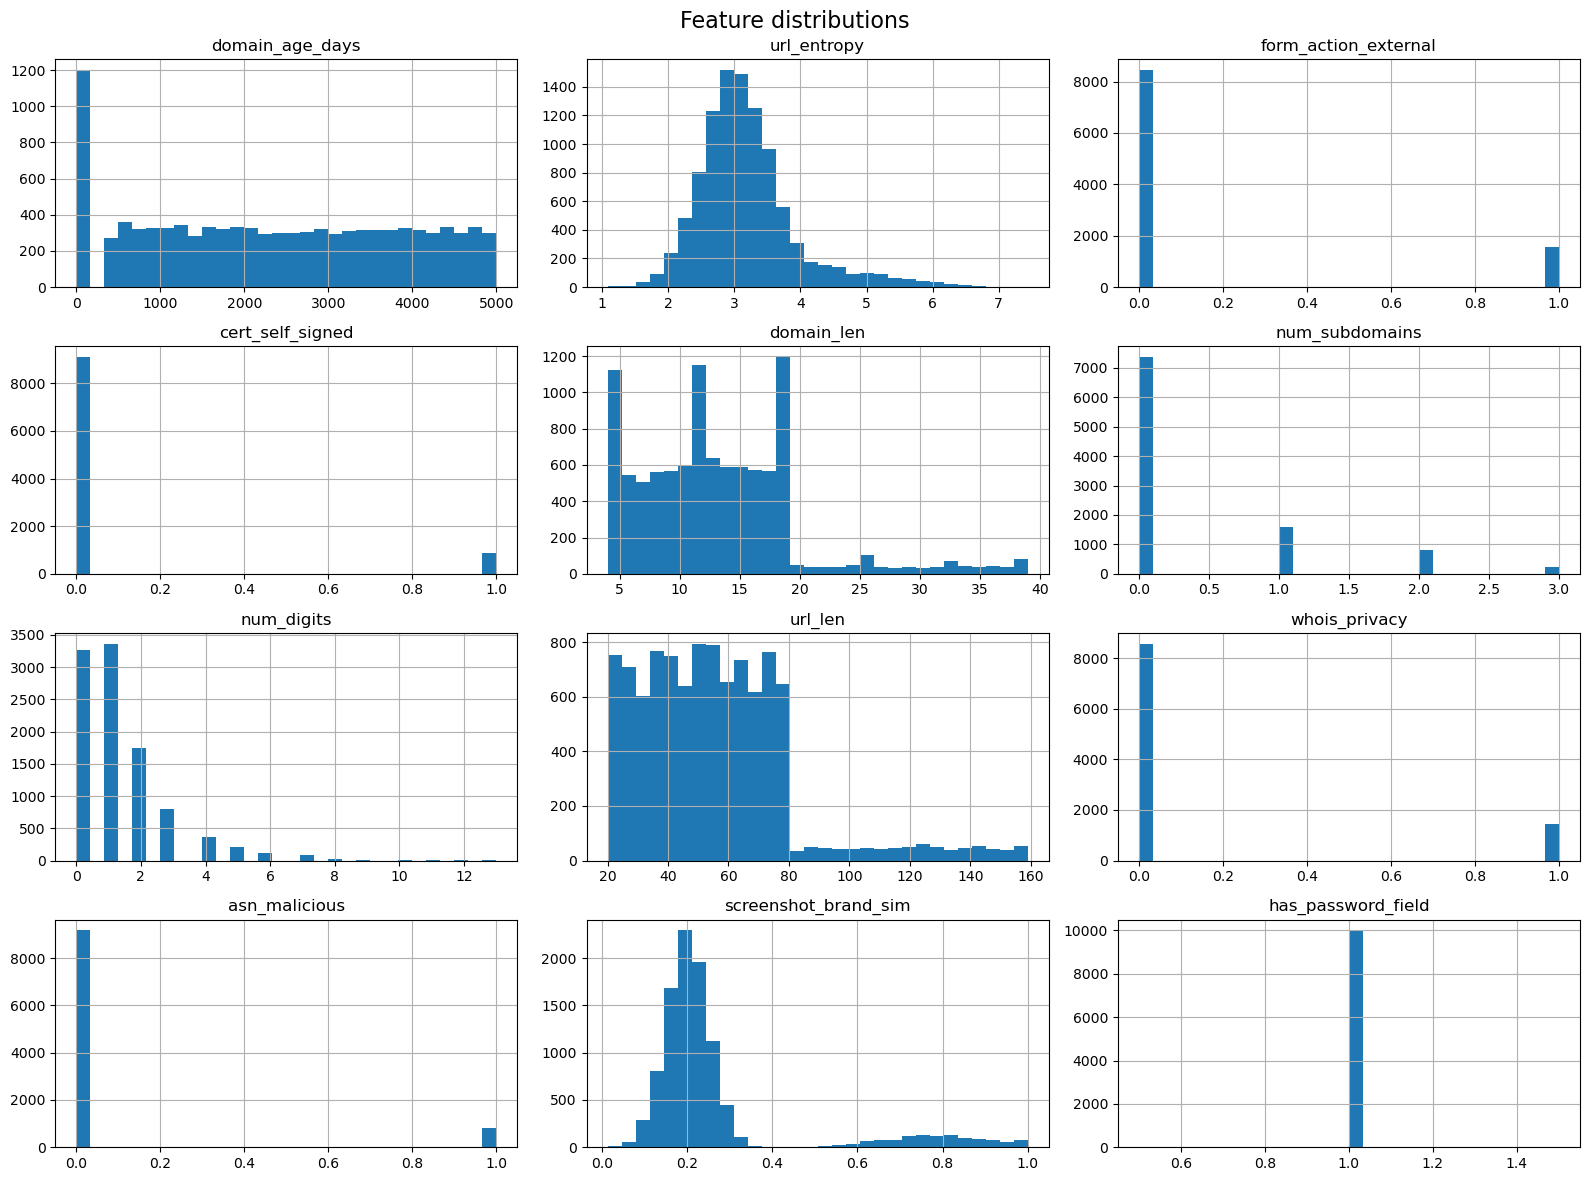

In [56]:
# Plot histograms for a subset of numeric features
df[FEATURE_COLUMNS].hist(bins=30, figsize=(16,12))
plt.suptitle("Feature distributions", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
#not needed
plt.figure(figsize=(12,8))
corr = df[FEATURE_COLUMNS + [target_col]].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation matrix")
plt.show()


NameError: name 'target_col' is not defined

<Figure size 1200x800 with 0 Axes>

In [57]:
from sklearn.model_selection import train_test_split

X = df[FEATURE_COLUMNS].astype(float)   # numeric features
y = df["label"].astype(int)             # target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# 6. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train / Test sizes:", X_train.shape, X_test.shape)


Train / Test sizes: (8000, 12) (2000, 12)


In [58]:
# Model training: prefer LightGBM if installed, otherwise RandomForest
from sklearn.metrics import roc_auc_score

use_lgb = _optional.get('lightgbm', False)
print("LightGBM available?", use_lgb)

if use_lgb:
    print("Training LightGBM (sklearn API wrapper) with a small grid search")
    model = LGBMClassifier(n_jobs=-1, random_state=42)
    # handle imbalance by setting scale_pos_weight
    pos = sum(y_train==1)
    neg = sum(y_train==0)
    model.set_params(scale_pos_weight = neg/pos)
    param_grid = {
        'n_estimators': [100, 300],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [31, 63]
    }
else:
    print("Training RandomForest as fallback")
    model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
    param_grid = {
        'n_estimators': [200, 500],
        'max_depth': [8, 16]
    }

pipeline = Pipeline([
    ('scaler', StandardScaler()),   # tree models don't require scaling but it's OK and useful for alternatives
    ('clf', model)
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, {'clf__' + k: v for k,v in param_grid.items()}, cv=cv, scoring='average_precision', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_
# Evaluate quickly
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


LightGBM available? False
Training RandomForest as fallback
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__max_depth': 8, 'clf__n_estimators': 200}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1760
           1       1.00      1.00      1.00       240

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC: 1.0


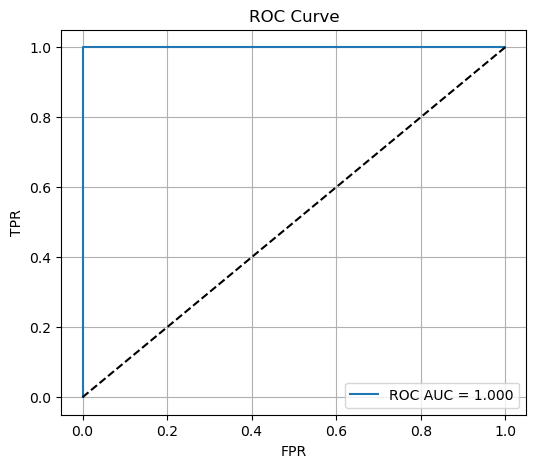

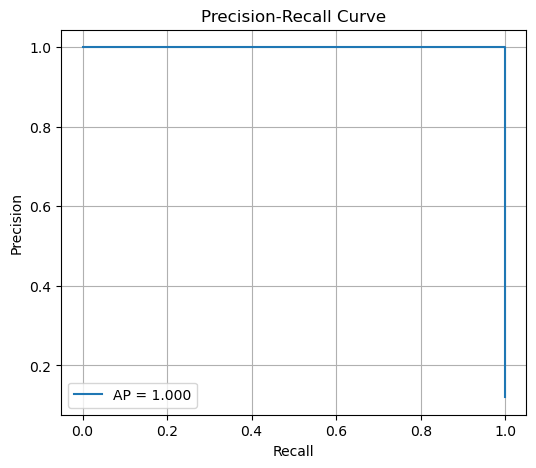

In [59]:
# ROC and Precision-Recall curves
from sklearn.metrics import precision_recall_curve, average_precision_score

y_proba = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'AP = {ap:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend(); plt.grid(True)
plt.show()


Sample Predictions with Features + Target:
      domain_age_days  url_entropy  form_action_external  cert_self_signed  \
7006             58.0       3.1732                   1.0               1.0   
8327           2693.0       3.3173                   0.0               0.0   
1998           4195.0       3.7089                   0.0               0.0   
9815           1234.0       2.9219                   0.0               0.0   
7093             72.0       5.3158                   1.0               1.0   

      domain_len  num_subdomains  num_digits  url_len  whois_privacy  \
7006        36.0             2.0         5.0    153.0            0.0   
8327        16.0             1.0         0.0     70.0            0.0   
1998         7.0             0.0         2.0     35.0            0.0   
9815        18.0             2.0         0.0     35.0            0.0   
7093        27.0             1.0         3.0     98.0            0.0   

      asn_malicious  screenshot_brand_sim  has_password

<Figure size 640x480 with 0 Axes>

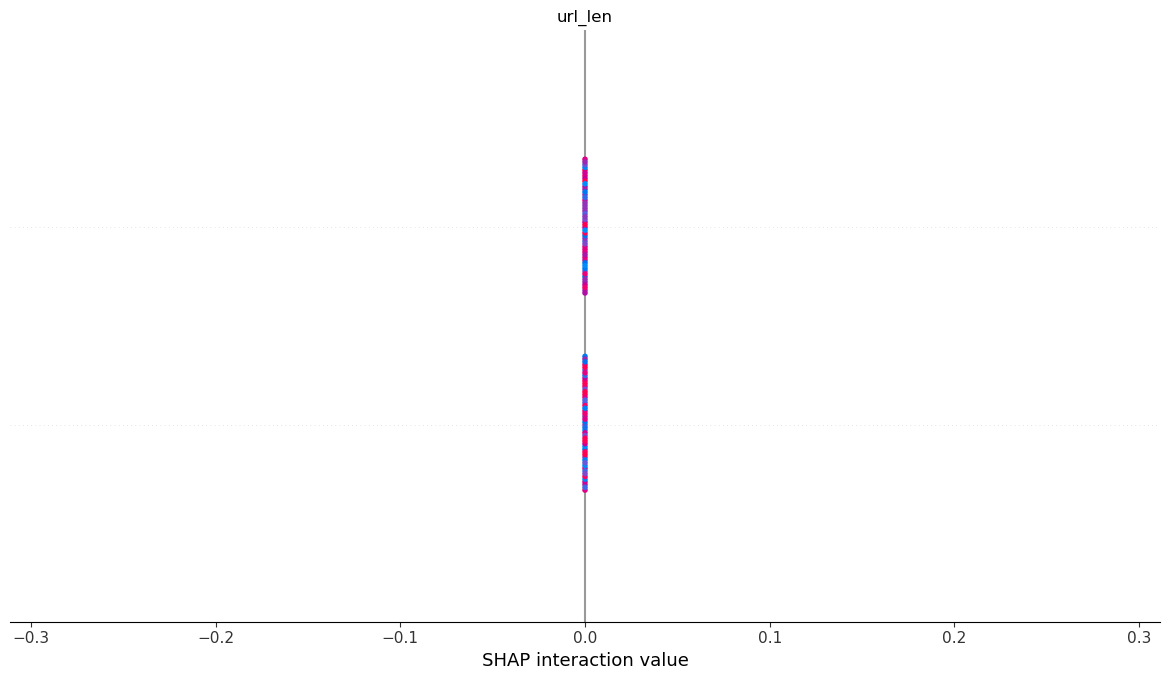

In [69]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Combine predictions with actual target
results_df = X_test.copy()
results_df["Actual"] = y_test.values
results_df["Predicted"] = y_pred

print("Sample Predictions with Features + Target:")
print(results_df.head())

# Explainability
FEATURE_COLUMNS = list(FEATURE_COLUMNS)  # ensure it's a list

if _optional.get('shap', False):
    print("Running SHAP explanation (may take a little time)")
    
    # Sample background and test data
    background = X_train.sample(n=min(200, len(X_train)), random_state=42)
    X_test_sample = X_test.sample(n=min(50, len(X_test)), random_state=42)
    
    # Create explainer with background
    explainer = shap.Explainer(best_model.named_steps['clf'], background)
    
    # Compute SHAP values for sampled test data
    shap_values = explainer(X_test_sample)
    
    # Plot with SAME sampled data
    shap.summary_plot(
        shap_values,
        features=X_test_sample,  # ✅ Critical: must match!
        feature_names=FEATURE_COLUMNS,
        show=True
    )
else:
    print("SHAP not installed — falling back to feature importances (if available)")
    try:
        importances = best_model.named_steps['clf'].feature_importances_
        fi = pd.Series(importances, index=FEATURE_COLUMNS).sort_values(ascending=False)

        # Display feature importances
        display(fi)
        plt.figure(figsize=(8,4))
        sns.barplot(x=fi.values, y=fi.index)
        plt.title('Feature Importances')
        plt.show()

        # Also print predictions with target
        print("\nPredictions vs Actual:")
        print(results_df.head())
    except Exception as e:
        print("Couldn't calculate feature importances:", e)

In [ ]:
# Save the trained pipeline for later inference
MODEL_OUT = "phish_detector_pipeline.joblib"
joblib.dump(best_model, MODEL_OUT)
print("Saved model to", MODEL_OUT)


Saved model to phish_detector_pipeline.joblib


Sample Predictions with Features + Target:
        URLLength  DomainLength  IsDomainIP  URLSimilarityIndex  \
173310       25.0          18.0         0.0               100.0   
62486        25.0          18.0         0.0               100.0   
14858        24.0          17.0         0.0               100.0   
82943        32.0          25.0         0.0               100.0   
72539        23.0          16.0         0.0               100.0   

        CharContinuationRate  TLDLegitimateProb  URLCharProb  TLDLength  \
173310              1.000000           0.522907     0.063855        3.0   
62486               0.727273           0.003322     0.048722        2.0   
14858               1.000000           0.522907     0.063283        3.0   
82943               1.000000           0.522907     0.056111        3.0   
72539               1.000000           0.522907     0.050065        3.0   

        NoOfSubDomain  HasObfuscation  ...  Crypto  HasCopyrightInfo  \
173310            1.0          

URLSimilarityIndex            1.973533e-01
NoOfExternalRef               1.680583e-01
LineOfCode                    1.333269e-01
NoOfImage                     1.110531e-01
NoOfSelfRef                   8.968632e-02
NoOfJS                        7.428584e-02
HasSocialNet                  4.323594e-02
NoOfCSS                       2.740155e-02
HasDescription                2.430962e-02
HasCopyrightInfo              2.277643e-02
NoOfOtherSpecialCharsInURL    1.339690e-02
IsHTTPS                       1.253021e-02
LargestLineLength             1.185598e-02
NoOfDegitsInURL               8.173875e-03
NoOfiFrame                    6.669301e-03
DomainTitleMatchScore         6.490949e-03
DegitRatioInURL               6.222290e-03
NoOfEmptyRef                  5.944975e-03
URLLength                     5.932120e-03
NoOfLettersInURL              5.791343e-03
HasSubmitButton               5.127823e-03
LetterRatioInURL              4.433764e-03
URLTitleMatchScore            3.176720e-03
IsResponsiv

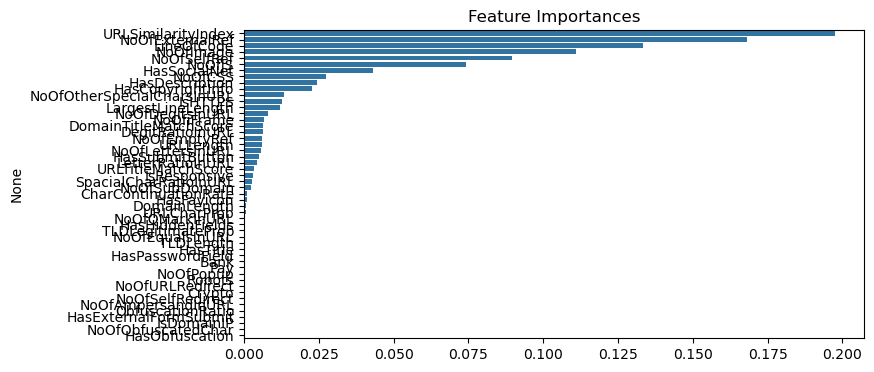


Predictions vs Actual:
        URLLength  DomainLength  IsDomainIP  URLSimilarityIndex  \
173310       25.0          18.0         0.0               100.0   
62486        25.0          18.0         0.0               100.0   
14858        24.0          17.0         0.0               100.0   
82943        32.0          25.0         0.0               100.0   
72539        23.0          16.0         0.0               100.0   

        CharContinuationRate  TLDLegitimateProb  URLCharProb  TLDLength  \
173310              1.000000           0.522907     0.063855        3.0   
62486               0.727273           0.003322     0.048722        2.0   
14858               1.000000           0.522907     0.063283        3.0   
82943               1.000000           0.522907     0.056111        3.0   
72539               1.000000           0.522907     0.050065        3.0   

        NoOfSubDomain  HasObfuscation  ...  Crypto  HasCopyrightInfo  \
173310            1.0             0.0  ...     0.0

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Combine predictions with actual target
results_df = X_test.copy()
results_df["Actual"] = y_test.values
results_df["Predicted"] = y_pred

print("Sample Predictions with Features + Target:")
print(results_df.head())

# Explainability
FEATURE_COLUMNS = list(FEATURE_COLUMNS)  # ensure it's a list

if _optional.get('shap', False):
    print("Running SHAP explanation (may take a little time)")
    explainer = shap.Explainer(best_model.named_steps['clf'], X_train)

    # Pick a small background sample
    background = X_train.sample(n=min(200, len(X_train)), random_state=42)

    # Compute SHAP values for test set
    shap_values = explainer(X_test.sample(n=min(50, len(X_test)), random_state=42))

    # SHAP summary plot
    shap.summary_plot(
        shap_values, 
        features=X_test, 
        feature_names=FEATURE_COLUMNS, 
        show=True
    )
else:
    print("SHAP not installed — falling back to feature importances (if available)")
    try:
        importances = best_model.named_steps['clf'].feature_importances_
        fi = pd.Series(importances, index=FEATURE_COLUMNS).sort_values(ascending=False)

        # Display feature importances
        display(fi)
        plt.figure(figsize=(8,4))
        sns.barplot(x=fi.values, y=fi.index)
        plt.title('Feature Importances')
        plt.show()

        # Also print predictions with target
        print("\nPredictions vs Actual:")
        print(results_df.head())
    except Exception as e:
        print("Couldn't calculate feature importances:", e)


In [ ]:
# Minimal scoring helper that accepts a dict of features and returns probability + explainable reasons
def score_from_features(feat_dict):
    # Ensure feature order
    x = np.array([[feat_dict[c] for c in FEATURE_COLUMNS]], dtype=float)
    proba = best_model.predict_proba(x)[0,1]
    # obtain local feature importances as a simple explanation
    try:
        clf = best_model.named_steps['clf']
        imp = getattr(clf, 'feature_importances_', None)
        if imp is not None:
            ranked = sorted(zip(FEATURE_COLUMNS, imp), key=lambda x: x[1], reverse=True)[:4]
            reasons = [f"{name}: importance={val:.3f}" for name,val in ranked]
        else:
            reasons = ["Top reasons not available (model lacks feature_importances_)"]
    except Exception as e:
        reasons = [f"Explanation error: {e}"]
    return {"probability": float(proba), "reasons": reasons}

# Example usage on a test sample
sample = X_test.iloc[0].to_dict()
print("Sample features:", sample)
print("Score:", score_from_features(sample))


Sample features: {'URLLength': 25.0, 'DomainLength': 18.0, 'IsDomainIP': 0.0, 'URLSimilarityIndex': 100.0, 'CharContinuationRate': 1.0, 'TLDLegitimateProb': 0.5229071, 'URLCharProb': 0.063854666, 'TLDLength': 3.0, 'NoOfSubDomain': 1.0, 'HasObfuscation': 0.0, 'NoOfObfuscatedChar': 0.0, 'ObfuscationRatio': 0.0, 'NoOfLettersInURL': 12.0, 'LetterRatioInURL': 0.48, 'NoOfDegitsInURL': 0.0, 'DegitRatioInURL': 0.0, 'NoOfEqualsInURL': 0.0, 'NoOfQMarkInURL': 0.0, 'NoOfAmpersandInURL': 0.0, 'NoOfOtherSpecialCharsInURL': 1.0, 'SpacialCharRatioInURL': 0.04, 'IsHTTPS': 1.0, 'LineOfCode': 978.0, 'LargestLineLength': 13968.0, 'HasTitle': 1.0, 'DomainTitleMatchScore': 100.0, 'URLTitleMatchScore': 100.0, 'HasFavicon': 0.0, 'Robots': 0.0, 'IsResponsive': 1.0, 'NoOfURLRedirect': 0.0, 'NoOfSelfRedirect': 0.0, 'HasDescription': 1.0, 'NoOfPopup': 0.0, 'NoOfiFrame': 0.0, 'HasExternalFormSubmit': 0.0, 'HasSocialNet': 1.0, 'HasSubmitButton': 1.0, 'HasHiddenFields': 1.0, 'HasPasswordField': 0.0, 'Bank': 0.0, 'Pa

/opt/anaconda3/envs/fraud_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import numpy as np

# Convert dict into DataFrame row
sample_features = {
    'URLLength': 25.0, 'DomainLength': 18.0, 'IsDomainIP': 0.0,
    'URLSimilarityIndex': 100.0, 'CharContinuationRate': 1.0,
    'TLDLegitimateProb': 0.5229071, 'URLCharProb': 0.063854666,
    'TLDLength': 3.0, 'NoOfSubDomain': 1.0, 'HasObfuscation': 0.0,
    'NoOfObfuscatedChar': 0.0, 'ObfuscationRatio': 0.0,
    'NoOfLettersInURL': 12.0, 'LetterRatioInURL': 0.48,
    'NoOfDegitsInURL': 0.0, 'DegitRatioInURL': 0.0,
    'NoOfEqualsInURL': 0.0, 'NoOfQMarkInURL': 0.0,
    'NoOfAmpersandInURL': 0.0, 'NoOfOtherSpecialCharsInURL': 1.0,
    'SpacialCharRatioInURL': 0.04, 'IsHTTPS': 1.0,
    'LineOfCode': 978.0, 'LargestLineLength': 13968.0,
    'HasTitle': 1.0, 'DomainTitleMatchScore': 100.0,
    'URLTitleMatchScore': 100.0, 'HasFavicon': 0.0,
    'Robots': 0.0, 'IsResponsive': 1.0, 'NoOfURLRedirect': 0.0,
    'NoOfSelfRedirect': 0.0, 'HasDescription': 1.0,
    'NoOfPopup': 0.0, 'NoOfiFrame': 0.0, 'HasExternalFormSubmit': 0.0,
    'HasSocialNet': 1.0, 'HasSubmitButton': 1.0, 'HasHiddenFields': 1.0,
    'HasPasswordField': 0.0, 'Bank': 0.0, 'Pay': 0.0, 'Crypto': 0.0,
    'HasCopyrightInfo': 1.0, 'NoOfImage': 16.0, 'NoOfCSS': 12.0,
    'NoOfJS': 29.0, 'NoOfSelfRef': 65.0, 'NoOfEmptyRef': 0.0,
    'NoOfExternalRef': 11.0
}
# your dict
sample_df = pd.DataFrame([sample_features])

# Predict class (0 or 1)
pred_class = best_model.predict(sample_df)[0]

# Predict probability
pred_prob = best_model.predict_proba(sample_df)[0][pred_class]

# Map class → human readable
label_map = {0: "Legitimate Website", 1: "Fraudulent Website"}
print(f"Prediction: {label_map[pred_class]} (probability = {pred_prob:.4f})")


Prediction: Fraudulent Website (probability = 0.9996)


In [ ]:
# Optional: export model to ONNX for deployment in other runtimes.
# This cell may require onnxmltools / skl2onnx; run only if you need ONNX and have packages installed.
try:
    from skl2onnx import convert_sklearn
    from skl2onnx.common.data_types import FloatTensorType
    initial_type = [('float_input', FloatTensorType([None, len(FEATURE_COLUMNS)]))]
    onx = convert_sklearn(best_model, initial_types=initial_type)
    onnx_path = "phish_detector.onnx"
    with open(onnx_path, "wb") as f:
        f.write(onx.SerializeToString())
    print("Saved ONNX model to", onnx_path)
except Exception as e:
    print("ONNX export skipped or failed (install skl2onnx/onnx). Error:", e)


In [ ]:
# ====== Evaluate model over the entire test set and show counts ======
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve

# 1) Get predicted probabilities and default predictions (threshold = 0.5)
probs = best_model.predict_proba(X_test)[:, 1]          # probability of class 1 (fraud)
preds_default = (probs >= 0.5).astype(int)              # default threshold 0.5

# 2) Counts: predicted fraud vs legit (using default threshold)
counts = pd.Series(preds_default).value_counts().sort_index()
print("Predicted counts (0 = legit, 1 = fraud):")
print(counts)
print(f"Predicted fraud proportion: {counts.get(1,0)/len(X_test):.3f}")

# 3) Compare to ground truth counts in test set
true_counts = pd.Series(y_test.values).value_counts().sort_index()
print("\nActual counts in test set (0 = legit, 1 = fraud):")
print(true_counts)
print(f"Actual fraud proportion: {true_counts.get(1,0)/len(y_test):.3f}")

# 4) Confusion matrix and classification report
cm = confusion_matrix(y_test, preds_default)
print("\nConfusion matrix (rows = true, cols = predicted):")
print(cm)

print("\nClassification report (threshold = 0.5):")
print(classification_report(y_test, preds_default, digits=4))

# 5) (Optional) Choose a threshold by maximizing F1 on the test set (or better: on validation set)
# WARNING: tuning on the test set biases evaluation — prefer to tune on a validation set.
best_t = 0.5
best_f1 = 0.0
for t in np.linspace(0.01, 0.99, 99):
    f1 = f1_score(y_test, (probs >= t).astype(int))
    if f1 > best_f1:
        best_f1 = f1
        best_t = t
print(f"\nBest F1 on test set (for info only): threshold={best_t:.3f}, F1={best_f1:.4f}")

# Apply that threshold if you want
preds_bestf1 = (probs >= best_t).astype(int)
print("\nCounts using best-F1 threshold:")
print(pd.Series(preds_bestf1).value_counts().sort_index())

print("\nClassification report (best-F1 threshold):")
print(classification_report(y_test, preds_bestf1, digits=4))

# 6) Show top examples of disagreements (false positives / false negatives)
res_df = X_test.copy().reset_index(drop=True)
res_df['true'] = y_test.values
res_df['prob'] = probs
res_df['pred_default'] = preds_default
res_df['pred_bestf1'] = preds_bestf1

# False negatives: true=1 but predicted 0 (missed fraud)
fn = res_df[(res_df['true']==1) & (res_df['pred_default']==0)].sort_values('prob', ascending=False)
# False positives: true=0 but predicted 1 (wrongly flagged)
fp = res_df[(res_df['true']==0) & (res_df['pred_default']==1)].sort_values('prob', ascending=False)

print(f"\nNumber of false negatives (missed fraud) at thresh=0.5: {len(fn)}")
print(f"Number of false positives (wrongly flagged) at thresh=0.5: {len(fp)}")

# Show a few mistaken examples with their top features and probability
print("\nSample false negatives (highest probs among missed frauds):")
display(fn.head(5)[['prob','true','pred_default'] + FEATURE_COLUMNS[:10]])  # show prob, true, pred and first 10 features

print("\nSample false positives (highest probs):")
display(fp.head(5)[['prob','true','pred_default'] + FEATURE_COLUMNS[:10]])


Predicted counts (0 = legit, 1 = fraud):
0    20189
1    26970
Name: count, dtype: int64
Predicted fraud proportion: 0.572

Actual counts in test set (0 = legit, 1 = fraud):
0    20189
1    26970
Name: count, dtype: int64
Actual fraud proportion: 0.572

Confusion matrix (rows = true, cols = predicted):
[[20189     0]
 [    0 26970]]

Classification report (threshold = 0.5):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     20189
           1     1.0000    1.0000    1.0000     26970

    accuracy                         1.0000     47159
   macro avg     1.0000    1.0000    1.0000     47159
weighted avg     1.0000    1.0000    1.0000     47159


Best F1 on test set (for info only): threshold=0.470, F1=1.0000

Counts using best-F1 threshold:
0    20189
1    26970
Name: count, dtype: int64

Classification report (best-F1 threshold):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     201

,prob,true,pred_default,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation



Sample false positives (highest probs):


,prob,true,pred_default,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation


In [ ]:
predicted_fraud_count = (best_model.predict_proba(X_test)[:,1] >= 0.5).sum()
flagged_idx = X_test.index[(best_model.predict_proba(X_test)[:,1] >= 0.5)]
flagged_urls = df.loc[flagged_idx, 'URL']
print(flagged_urls.head(50))



173310              https://www.lojewelers.com
62486               https://www.hengqin.gov.cn
14858                https://www.reedgroup.com
82943        https://www.indiaflowersgifts.com
72539                 https://www.cozywozy.com
42091            https://www.fibre-systems.com
110432               https://www.innovatext.hu
90325     https://www.saint-denis-basilique.fr
17979                https://www.energia.co.jp
65867         https://www.officeingarden.co.uk
64796                https://www.nathaninc.com
37278                     https://www.iucr.org
63612                      https://www.tpr.org
192398                   https://www.jacvam.jp
144893              https://www.buildanest.org
144665                  https://www.ezanga.com
37915                  https://www.xywrite.com
155943               https://www.chapstick.com
215223              https://www.moneytrail.net
166567                  https://www.frustek.si
7507         https://www.powerhousefilms.co.uk
73718        

## Optional: Example FastAPI scoring endpoint (skeleton)

Below is a minimal example of how you'd serve the saved pipeline with FastAPI. This is *not* run inside the notebook automatically; save as `server.py` and run with `uvicorn server:app --reload` after `pip install fastapi uvicorn`.

In [ ]:
# FastAPI skeleton (save as server.py)
fastapi_server_code = r'''
from fastapi import FastAPI
from pydantic import BaseModel
import joblib

MODEL_PATH = "phish_detector_pipeline.joblib"
model = joblib.load(MODEL_PATH)

class Features(BaseModel):
    domain_age_days: float
    url_entropy: float
    form_action_external: int
    cert_self_signed: int
    domain_len: float
    num_subdomains: float
    num_digits: float
    url_len: float
    whois_privacy: int
    asn_malicious: int
    screenshot_brand_sim: float
    has_password_field: int

app = FastAPI()

@app.post("/score")
def score(f: Features):
    feat_order = ['domain_age_days','url_entropy','form_action_external','cert_self_signed',
                  'domain_len','num_subdomains','num_digits','url_len','whois_privacy',
                  'asn_malicious','screenshot_brand_sim','has_password_field']
    x = [[getattr(f, c) for c in feat_order]]
    proba = model.predict_proba(x)[0][1]
    return {"probability": float(proba)}
'''
print("FastAPI skeleton (server.py) saved in variable `fastapi_server_code`. Copy to a file to run with uvicorn.")


# Next steps & deployment notes

**To move this to production:**
- Replace synthetic data with a real labeled dataset of login pages (phishing + legitimate).
- Add feature extractors that parse real page HTML, TLS certs, WHOIS, ASN lookups and screenshot embeddings (see main project plan).
- Consider local inference (browser extension + ONNX/WASM) for privacy or server-side inference behind authenticated API for heavy checks.
- Implement a user feedback loop and retraining pipeline; log only metadata with user consent.

**Privacy & ethics (must):**
- Never log or transmit credentials (passwords, MFA codes).
- Require explicit user consent for any telemetry.
- Provide an easy way to delete user telemetry and comply with GDPR/CCPA.
